### Imports

In [33]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc

from tqdm.notebook import tqdm

from gpolnel.problems.inductive_programming import SML
from gpolnel.problems.neuroevolution import SMLNN
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC, rhh, full, prm_full, nn_init, nn_init_individual
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, prm_gs_xo, prm_gs_mtn, prm_point_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn, nn_xo, prm_nn_mtn
from gpolnel.operators.selectors import prm_tournament, roulette_wheel, double_tournament
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from gpolnel.utils.neuroevolution import _feedforward_nn

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import neat
import visualize

In [2]:
X = pd.read_csv('datamart/data_project_nel.csv')
y = pd.read_csv('datamart/y_lactose.csv')
y

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402
...,...
319,4.891620
320,4.800946
321,4.916133
322,5.024776


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lactation                 324 non-null    int64  
 1   delivery_age_years        324 non-null    float64
 2   dim                       324 non-null    int64  
 3   dry_days                  177 non-null    float64
 4   forage_kg_day             324 non-null    float64
 5   rumination_min_day        324 non-null    float64
 6   milk_kg_day               324 non-null    float64
 7   milk_kg_min_robot         324 non-null    float64
 8   milkings_day              324 non-null    float64
 9   errors_by_100_milkings    324 non-null    float64
 10  high_cdt_by_100_milkings  324 non-null    float64
 11  watery_by_100_milkings    324 non-null    float64
 12  refusals_by_milking       324 non-null    float64
 13  colostrum_separated_kg    324 non-null    float64
dtypes: float64

Since dataset is quite small (only has 324 rows) and dry_days feature has 147 missing values that cannot be filled using any logic, as cow did not have any dry days, we will drop this feature not to lose observations.

In [4]:
X = X[X.columns.drop('dry_days')]

### Data exploration and preprocessing

Since we should rely only train data while doing the preprocessing we will split data into train, val and test. After it we will do data exploration and preprocessing

In [5]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2)

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))


Train:	158
Val:	68
Test:	98
Total:	324


In [6]:
X_train

,lactation,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
133,2,2.833333,334,4.110359,560.005970,37.492814,4.807242,2.140719,0.279720,0.000000,0.000000,0.018182,0.0
221,1,1.833333,310,4.900871,453.147910,34.244839,2.474946,3.016129,0.000000,0.000000,0.000000,0.349733,0.0
55,2,3.666667,284,4.582817,574.582456,41.941901,2.902560,2.200704,0.640000,0.000000,0.000000,0.041600,43.7
22,5,6.000000,308,4.493409,521.967638,39.289935,3.838451,2.503247,0.000000,0.000000,0.000000,0.063554,0.0
281,1,1.750000,318,4.446509,550.905956,30.713836,1.647146,2.830189,10.888889,0.666667,0.555556,0.286667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,3,4.000000,287,4.579129,564.170139,46.569686,1.770747,2.181185,0.319489,0.000000,0.000000,0.070288,0.0
69,2,2.833333,280,4.463857,426.355872,35.073571,3.932714,2.889286,1.236094,0.000000,0.000000,0.365884,6.4
48,4,4.916667,369,4.525691,611.240541,48.278591,4.267227,2.246612,1.206273,0.000000,0.000000,0.009650,25.9
215,1,1.750000,400,4.687075,499.384040,34.305500,2.390338,2.675000,1.214953,0.000000,0.000000,0.291589,0.0


In [7]:
y_train

,lactose_percent
133,4.874195
221,4.826024
55,4.810900
22,4.827283
281,4.896059
...,...
93,4.794831
69,5.007344
48,4.866383
215,4.994884


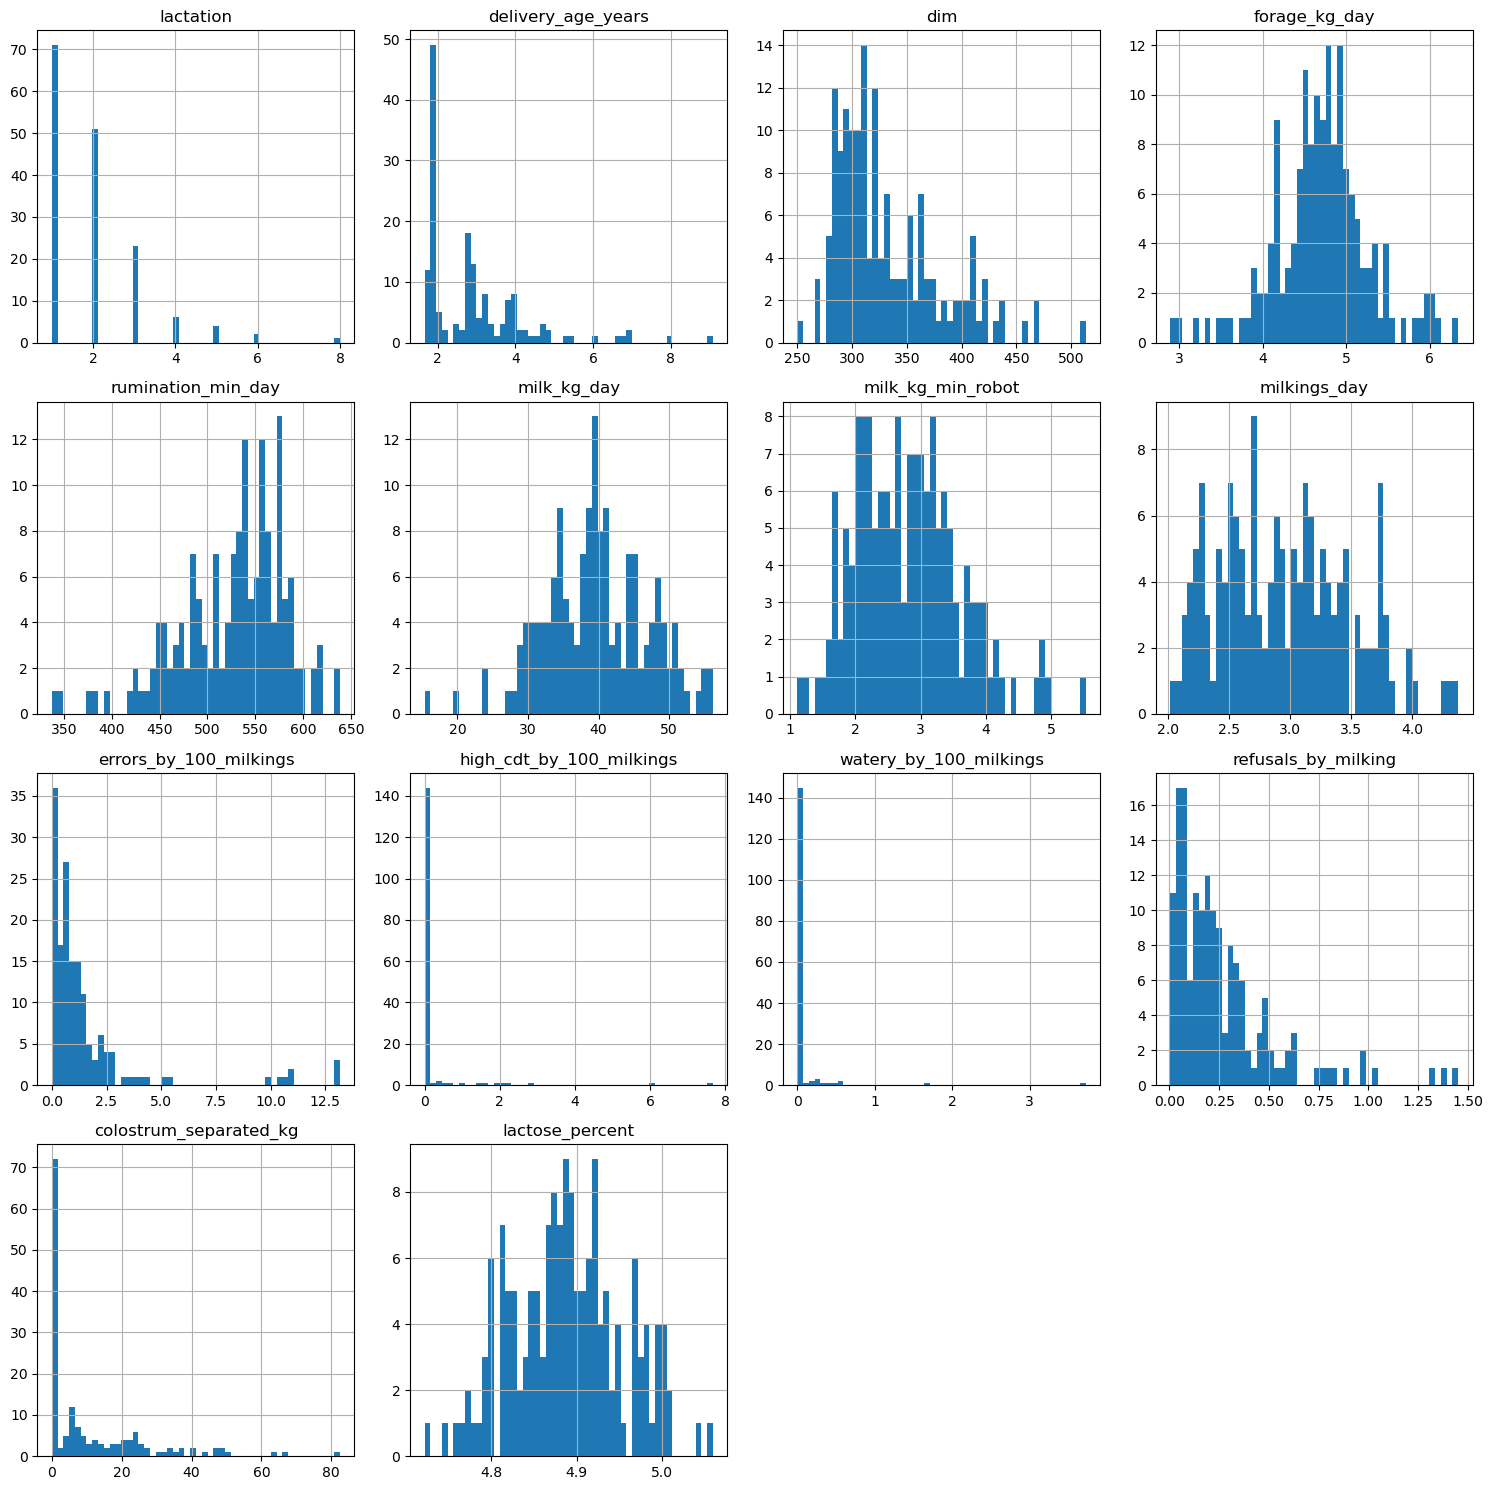

In [8]:
pd.concat([X_train, y_train], axis = 1).hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

Our data has outliers and a lot of skewness as we see from distributions. For GP algorithms it is not that crucial to fix it as there are no statistical assumptions such as we have with Linear models. However, it might still help to improve the perfomance. Moreover, we will use simple Neaural Networks, for which it is important and might affect the results. That is why we will fix it later

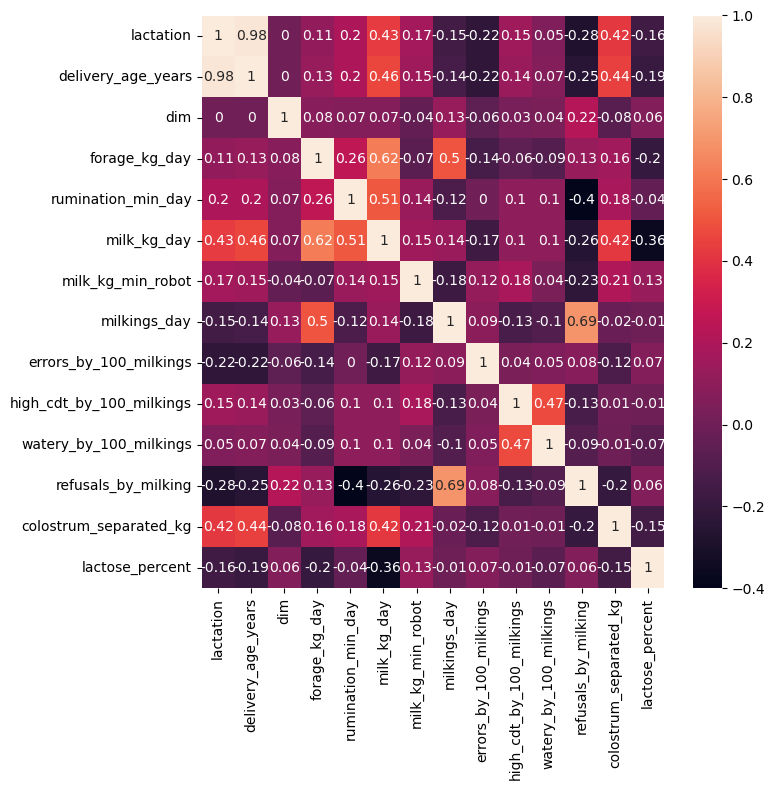

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(np.round(pd.concat([X_train, y_train], axis = 1).corr(),2), annot=True)
plt.grid(False)
plt.tight_layout()
plt.show()

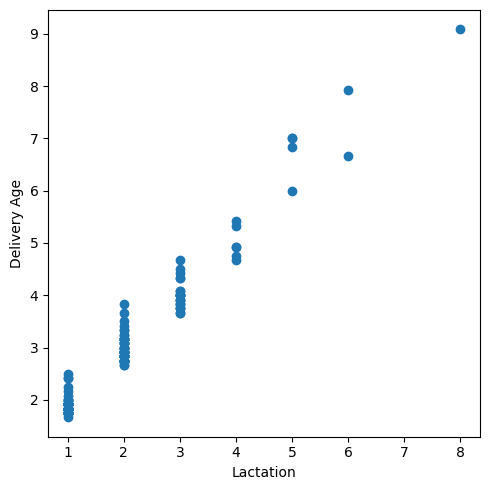

In [10]:
#Explore lactation and delivery_age_years

plt.figure(figsize=(5,5))
plt.scatter(X_train['lactation'], X_train['delivery_age_years'])
plt.xlabel('Lactation')
plt.ylabel('Delivery Age')
plt.grid(False)
plt.tight_layout()
plt.show()

- From the heatmap we see that lactation and delivery_age_years are almost perfectly correleted meaning that we can use one of them. We will remove lactation as it has less variability comapring to delivery_age_years
- There are no other strong correlations in our data
- Strongest correlation with target is -0.36 (still quite small number) for milk_kg_day, meaning that in our data the more milk is produced by cow per day the lower is lactose level. 

In [11]:
X_train = X_train[X_train.columns.drop('lactation')]
X_val = X_val[X_val.columns.drop('lactation')]
X_test = X_test[X_test.columns.drop('lactation')]

In [12]:
# Exploring skewness and possible tranformations

for k in range(len(X_train.columns)):
    i = X_train.columns[k]
    print(i)
    print("Skewness: {}".format(sc.skew(X_train[i])))
    if sc.skew(X_train[i]) > 0:
        print("Skewness after log transform: {}".format(sc.skew(np.log1p(X_train[i]))))
        print("Skewness after sqrt transform: {}".format(sc.skew(np.sqrt(X_train[i]))))
    else:
        print("Skewness after squared transform: {}".format(sc.skew(X_train[i]**2)))
    print('\n')
    # plt.figure(figsize=(5, 3))
    # sns.histplot(X_train[i]**0.5, bins=30, kde=True)
    plt.show()

delivery_age_years
Skewness: 1.8555628204971886
Skewness after log transform: 0.9487813578053107
Skewness after sqrt transform: 1.2339191927804463


dim
Skewness: 1.1497411518162417
Skewness after log transform: 0.8406213090263617
Skewness after sqrt transform: 0.9903879618967192


forage_kg_day
Skewness: -0.11249927380758144
Skewness after squared transform: 0.4443410102604845


rumination_min_day
Skewness: -0.8095271495341474
Skewness after squared transform: -0.4813787342609805


milk_kg_day
Skewness: -0.1185513458848651
Skewness after squared transform: 0.43178359988284065


milk_kg_min_robot
Skewness: 0.5790859857488777
Skewness after log transform: 0.011650894262377344
Skewness after sqrt transform: 0.18694774184472793


milkings_day
Skewness: 0.36215227912122955
Skewness after log transform: 0.11993954708911854
Skewness after sqrt transform: 0.19870578739705722


errors_by_100_milkings
Skewness: 3.2534975281841434
Skewness after log transform: 1.3101412055960173
Skewness after s

We will apply following transformations to fix positive and negative skewness:

Sqrt
- errors_by_100_milkings
- high_cdt_by_100_milkings
- watery_by_100_milkings
- refusals_by_milking

Log
- delivery_age_years
- dim
- milk_kg_min_robot
- colostrum_separated_kg

Square
- rumination_min_day

In [13]:
for i in ['errors_by_100_milkings', 'high_cdt_by_100_milkings', 'watery_by_100_milkings', 'refusals_by_milking']:
    X_train[i] = np.sqrt(X_train[i])
    X_val[i] = np.sqrt(X_val[i])
    X_test[i] = np.sqrt(X_test[i])

for i in ['delivery_age_years', 'dim', 'milk_kg_min_robot', 'colostrum_separated_kg']:
    X_train[i] = np.log1p(X_train[i])
    X_val[i] = np.log1p(X_val[i])
    X_test[i] = np.log1p(X_test[i])

for i in ['rumination_min_day']:
    X_train[i] = X_train[i]**2
    X_val[i] = X_val[i]**2
    X_test[i] = X_test[i]**2



/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_12959/2647383726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = np.sqrt(X_train[i])
/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_12959/2647383726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = np.log1p(X_train[i])
/var/folders/kk/jn6jnrpj6_30s05tyyfmmk9h0000gn/T/ipykernel_12959/2647383726.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

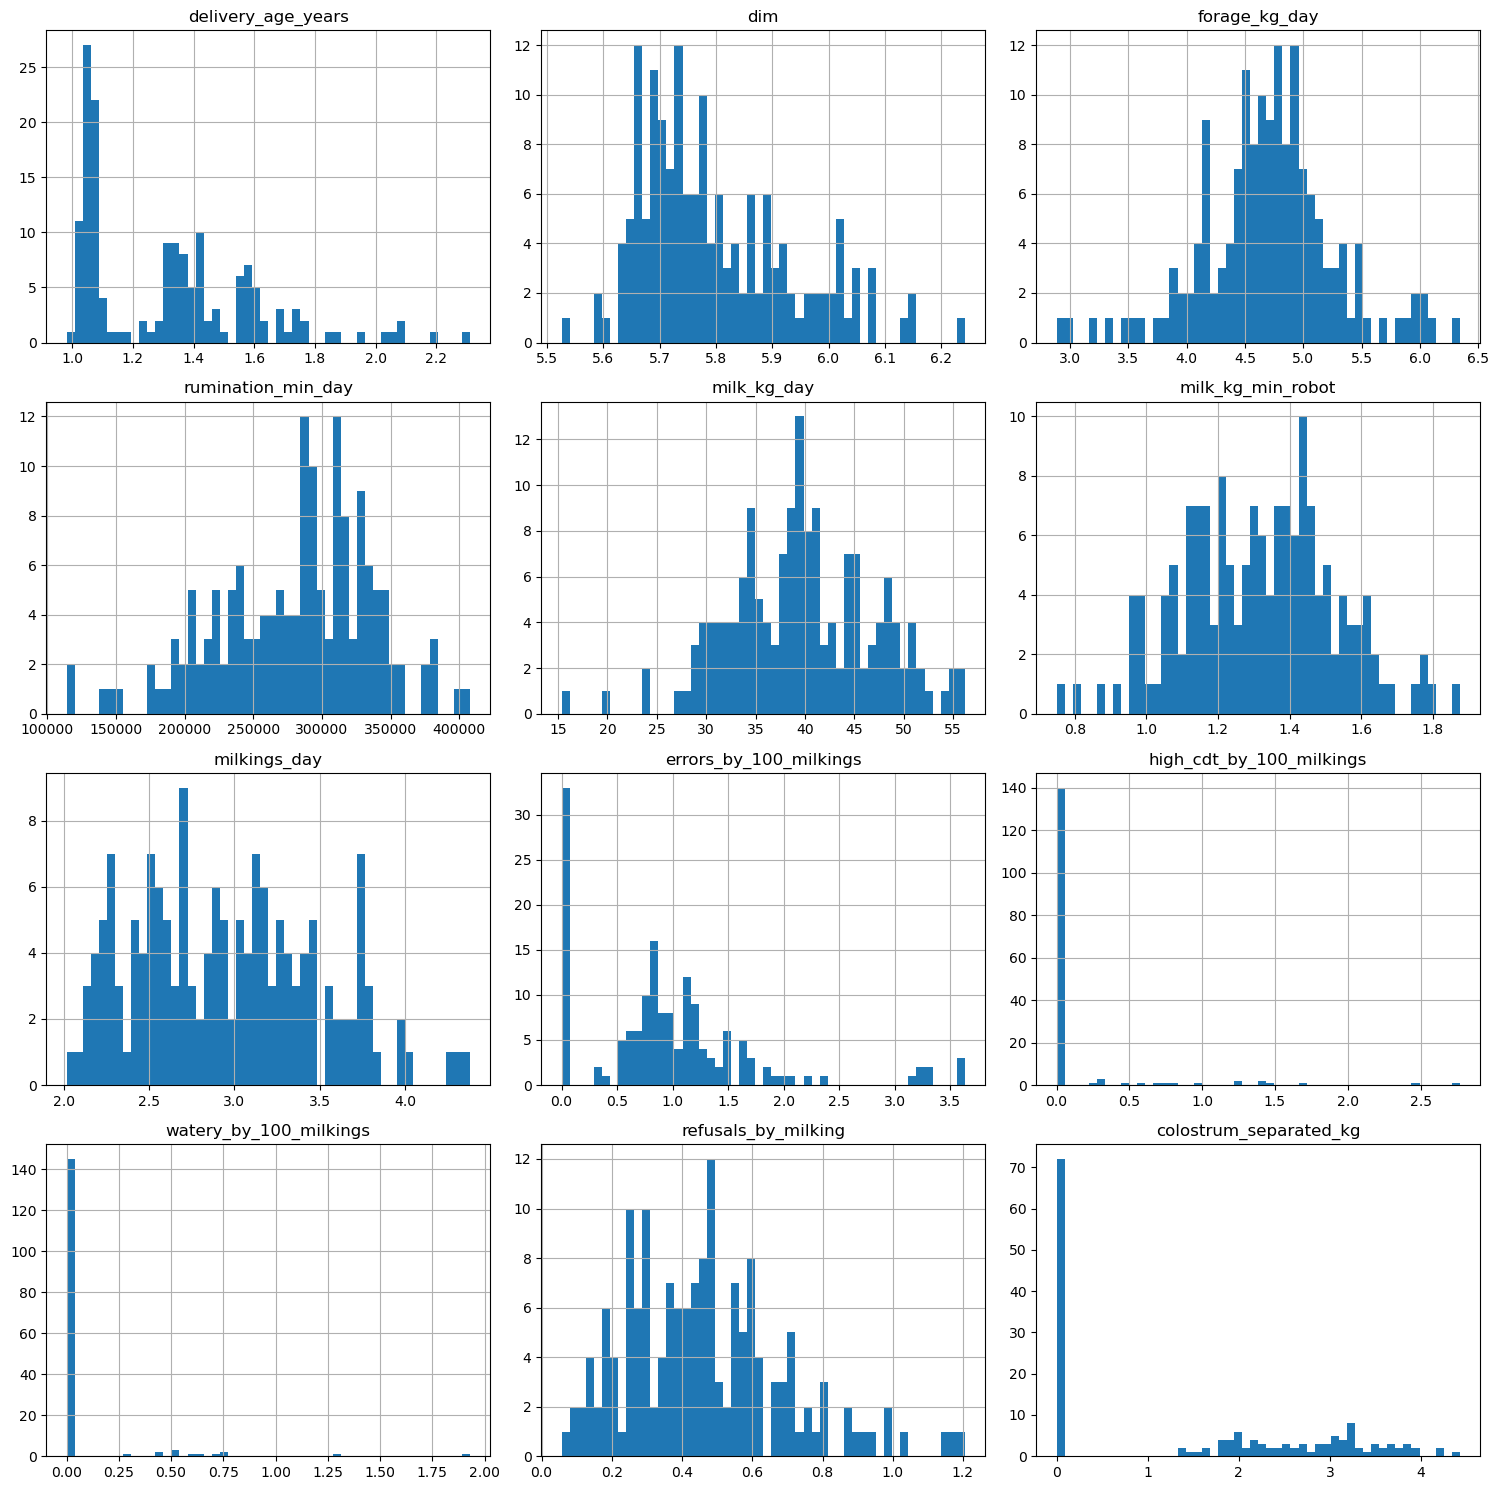

In [14]:
X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

It looks less skewed now and we will try to identify outliers using visual approach, exploring distributions from plots. Replace them with NaN values in train, val, test and then use KNN Imputer fitted with train data to fill these misisng values

In [15]:
X_train.columns

Index(['delivery_age_years', 'dim', 'forage_kg_day', 'rumination_min_day',
       'milk_kg_day', 'milk_kg_min_robot', 'milkings_day',
       'errors_by_100_milkings', 'high_cdt_by_100_milkings',
       'watery_by_100_milkings', 'refusals_by_milking',
       'colostrum_separated_kg'],
      dtype='object')

In [16]:
X_train.loc[X_train['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_train.loc[X_train['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_train.loc[X_train['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_train.loc[X_train['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_train.loc[X_train['milkings_day'] > 4, 'milkings_day'] = np.nan
X_train.loc[X_train['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_train.loc[X_train['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_train.loc[X_train['dim'] > 6.1, 'dim'] = np.nan
X_train.loc[X_train['dim'] < 5.6, 'dim'] = np.nan
X_train.loc[X_train['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_train.loc[X_train['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 133 to 86
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   delivery_age_years        149 non-null    float64
 1   dim                       151 non-null    float64
 2   forage_kg_day             149 non-null    float64
 3   rumination_min_day        151 non-null    float64
 4   milk_kg_day               154 non-null    float64
 5   milk_kg_min_robot         150 non-null    float64
 6   milkings_day              154 non-null    float64
 7   errors_by_100_milkings    150 non-null    float64
 8   high_cdt_by_100_milkings  156 non-null    float64
 9   watery_by_100_milkings    156 non-null    float64
 10  refusals_by_milking       154 non-null    float64
 11  colostrum_separated_kg    155 non-null    float64
dtypes: float64(12)
memory usage: 16.0 KB


In [17]:
X_val.loc[X_val['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_val.loc[X_val['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_val.loc[X_val['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_val.loc[X_val['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_val.loc[X_val['milkings_day'] > 4, 'milkings_day'] = np.nan
X_val.loc[X_val['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_val.loc[X_val['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_val.loc[X_val['dim'] > 6.1, 'dim'] = np.nan
X_val.loc[X_val['dim'] < 5.6, 'dim'] = np.nan
X_val.loc[X_val['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_val.loc[X_val['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_val.loc[X_val['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_val.loc[X_val['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_val.loc[X_val['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_val.loc[X_val['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_val.loc[X_val['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

X_test.loc[X_test['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_test.loc[X_test['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_test.loc[X_test['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_test.loc[X_test['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_test.loc[X_test['milkings_day'] > 4, 'milkings_day'] = np.nan
X_test.loc[X_test['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_test.loc[X_test['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_test.loc[X_test['dim'] > 6.1, 'dim'] = np.nan
X_test.loc[X_test['dim'] < 5.6, 'dim'] = np.nan
X_test.loc[X_test['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_test.loc[X_test['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

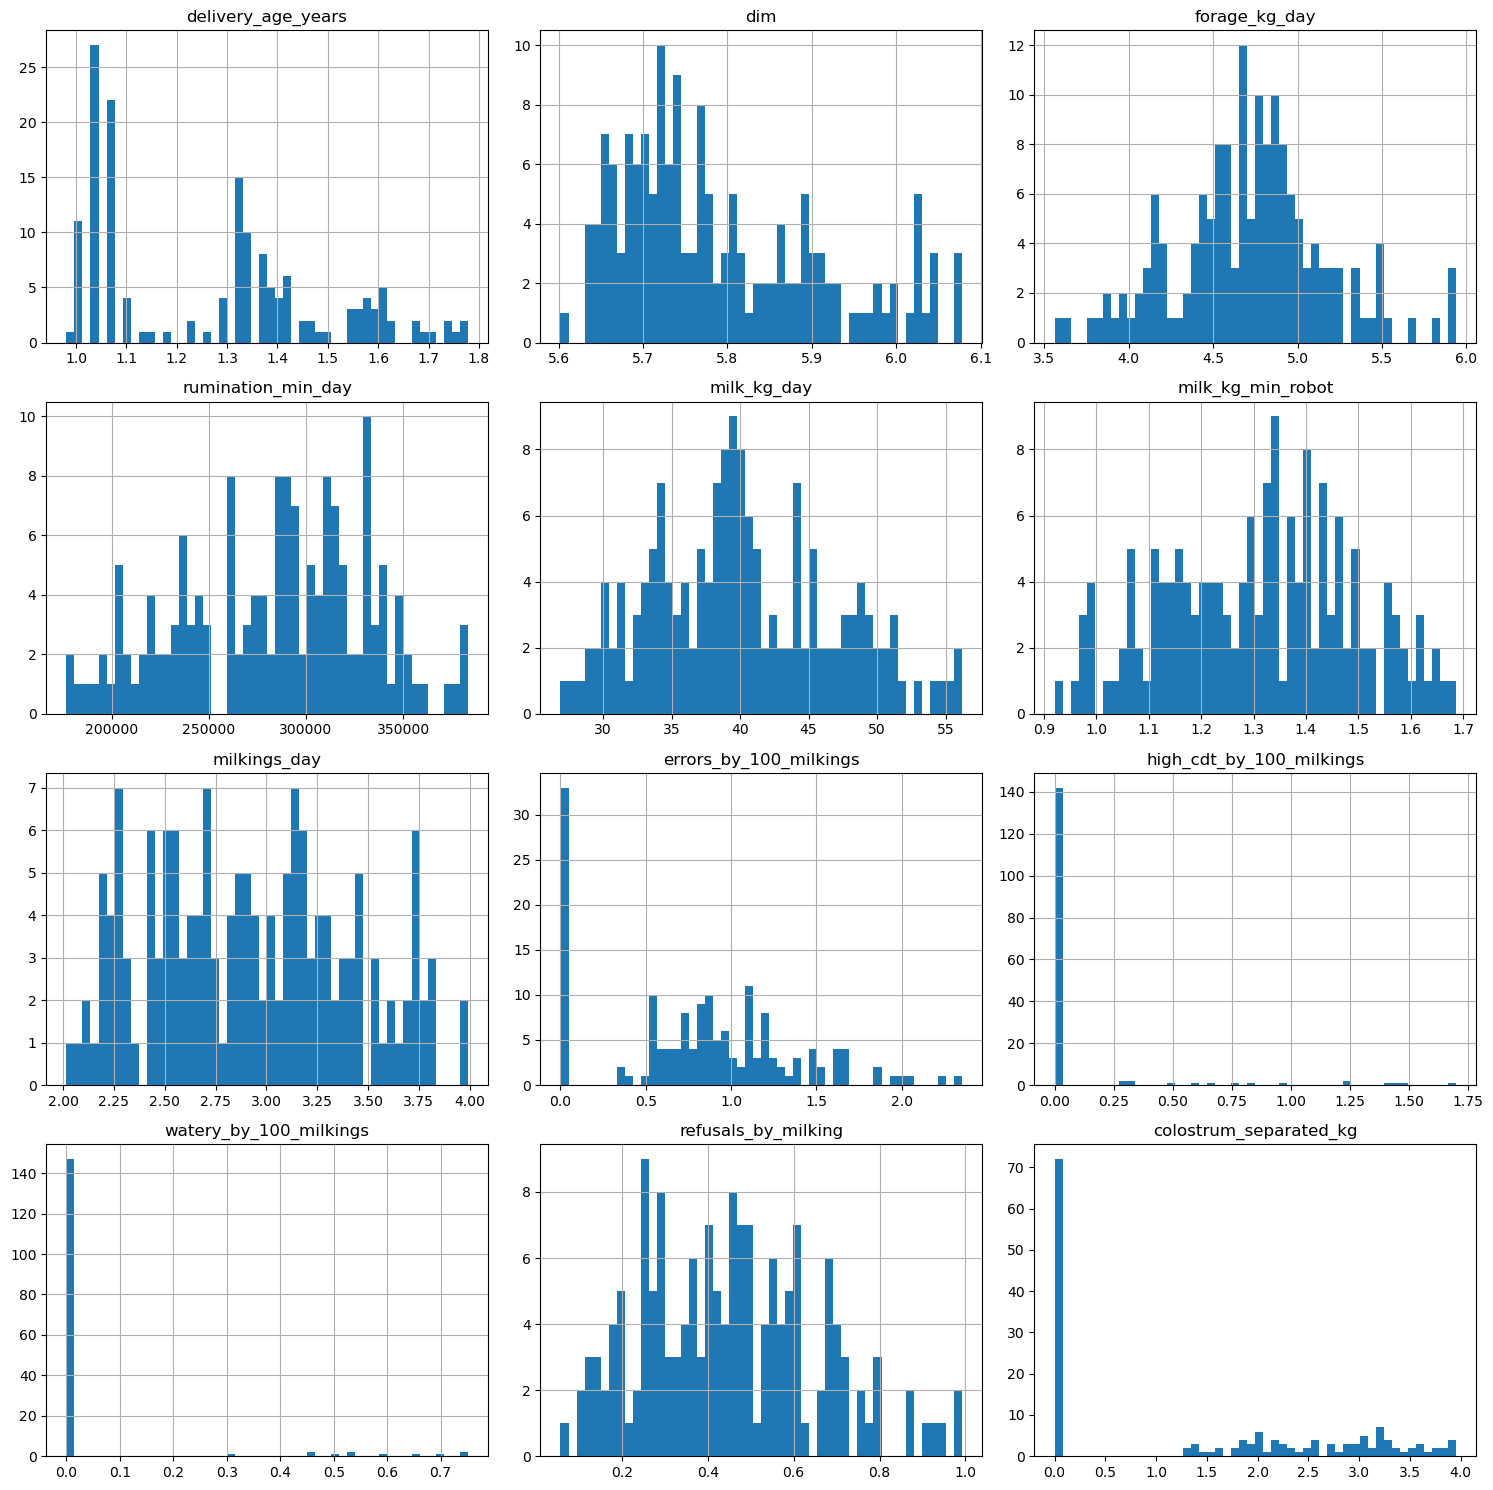

In [18]:
imputer = KNNImputer(n_neighbors=5)  

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_train.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns, index=X_test.index)

X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

In [19]:
X_train

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
133,1.343735,5.814131,4.110359,313606.686603,37.492814,1.336791,2.140719,0.528886,0.000000,0.000000,0.134840,0.000000
221,1.041454,5.739793,4.900871,205343.028308,34.244839,1.245579,3.016129,0.000000,0.000000,0.000000,0.591382,0.000000
55,1.540445,5.652489,4.582817,330144.998904,41.941901,1.361633,2.200704,0.800000,0.000000,0.000000,0.203961,3.799974
22,1.292482,5.733341,4.493409,272450.214640,39.289935,1.576595,2.503247,0.000000,0.000000,0.000000,0.252099,0.000000
281,1.011601,5.765191,4.446509,303497.372481,30.713836,0.973482,2.830189,0.563057,0.816497,0.745356,0.535413,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
93,1.609438,5.662960,4.579129,318287.945614,46.569686,1.019117,2.181185,0.565233,0.000000,0.000000,0.265118,0.000000
69,1.343735,5.638355,4.463857,181779.329492,35.073571,1.595889,2.889286,1.111798,0.000000,0.000000,0.604883,2.001480
48,1.777773,5.913503,4.525691,373614.998400,48.278591,1.661504,2.246612,1.098304,0.000000,0.000000,0.098235,3.292126
215,1.011601,5.993961,4.687075,249384.419307,34.305500,1.220930,2.675000,1.102249,0.000000,0.000000,0.539990,0.000000


In [20]:
y_train

,lactose_percent
133,4.874195
221,4.826024
55,4.810900
22,4.827283
281,4.896059
...,...
93,4.794831
69,5.007344
48,4.866383
215,4.994884


Final step is to scale all data

In [21]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# scaler = MinMaxScaler()
# y_train = scaler.fit_transform(y_train)
# y_val = scaler.transform(y_val)
# y_test = scaler.transform(y_test)

Before applying models we just need to convert data to tensors and create data loaders, since we wil work with Pytorch

In [22]:
#convert dataframes to tensors

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(1,-1)[0]

# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(1,-1)[0]
# y_val = torch.tensor(y_val, dtype=torch.float32).reshape(1,-1)[0]
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(1,-1)[0]


print(X_train.shape, y_train.shape)

torch.Size([158, 12]) torch.Size([158])


In [23]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True

In [24]:
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)


Batch size: 158
Total batches: 1

Train:	158
Val:	68
Test:	98
Total:	324


### GP

In [44]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}

pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=1
)

In [45]:
ps = 1000
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)


In [46]:
mheuristic._initialize()

In [47]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.repr_}, fitness {mheuristic.best_sol.fit}\n\n')


GP population: <class 'gpolnel.utils.population.Population'> (1000 individuals)

Poppulation fitness tensor([5.5886, 4.4494, 4.5508], device='mps:0')...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 6, tensor(-0.9433, device='mps:0'), 0, 3], fitness 5.588613033294678
Individual 1: [add, add, 0, 6, sub, 8, 10], fitness 4.449448585510254
Individual 2: [sub, 6, sub, 5, 10], fitness 4.550753116607666

GP best individual [sub, sub, 5, div, 3, tensor(-0.2263, device='mps:0'), 3], fitness 2.754755735397339




In [48]:
# # Log settings
# file_dir = './log/'
# file_name = 'intro.log'
# log_path = file_dir + file_name
# if os.path.exists(file_dir + file_name):
#     os.remove(file_dir + file_name)
# if not os.path.exists(file_dir):
#     os.makedirs(file_dir)

# Learning
n_iter = 25
mheuristic.solve(
    n_iter,
    verbose=3, 
    # log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 3        1.76722          1.89574               0.576 | 5.75468                   11.0512
1          | 11       1.15732          1.2198                1.311 | 3.58064                   1.77621
2          | 21       0.600029         0.621946              1.455 | 3.02356                   3.44862
3          | 21       0.488785         0.565152              1.823 | 2.11515                   1.36523
4          | 17       0.344193         0.343129              1.615 | 

In [49]:
for i in range(10):
    print(mheuristic.pop.individuals[i].repr_)

[add, add, add, tensor(0.7276, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), div, 10, 10, div, 10, 10]
[add, add, add, tensor(0.7276, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0')]
[add, 0, 8]
[add, add, 8, add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), div, 10, 10]
[tensor(0.8611, device='mps:0')]
[add, add, add, tensor(0.7276, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), add, tensor(0.7276, device='mps:0'), add, add, add, tensor(0.7276, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.8611, device='mps:0'), div, 10, 10, div, 10, 10]
[add, add, add, tensor(0.7276, device='mps:0'), add, tensor(0.7276, device='mps:0'), tensor(0.86

In [50]:
mheuristic.best_sol.printTree()

add( add( add( 0.7276, add( 0.7276, 0.8611 ) ) add( 0.7276, 0.8611 ) ) div( div( x_10, x_10 ) sub( x_11, x_11 ) ) )


### GSGP

In [52]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml_gs = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'device': device,
    'n_batches': 1
}

pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val
)

In [53]:
to, by = 5.0, 0.25
ms = torch.arange(by, to + by, by, device=device)

print(ms)

tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500,
        2.5000, 2.7500, 3.0000, 3.2500, 3.5000, 3.7500, 4.0000, 4.2500, 4.5000,
        4.7500, 5.0000], device='mps:0')


In [55]:
ps = 500
selection_pressure = .01
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=rhh,
    selector=prm_tournament(pressure=selection_pressure),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
    mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)

In [56]:
mheuristic._initialize()

In [57]:
mheuristic.best_sol.fit

tensor(2.4722, device='mps:0')

In [58]:
n_iter = 10
mheuristic.solve(
    n_iter=n_iter,
    verbose=5, log=2, 
    # log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 15       2.46031          11.8912               0.501 | 8.39768                   30.4575
1          | 14       1.02553          1.45504               1.487 | 3.74967                  0.509211
2          | 21       0.937947         1.21095               2.770 | 3.04641                  0.479707
3          | 28       0.927822         1.17467               5.579 | 2.27666                  0.447489
4          | 179      0.712183         0.650968              9.505 | 

KeyboardInterrupt: 

### Simple ML

In [59]:
# Simple mean RMSE
mean_squared_error(y_val, y_val-y_val + y_train.mean())**0.5

0.06761843149086542

In [60]:
rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)

In [61]:
#RF RMSE
mean_squared_error(y_val, rf.predict(X_val))**0.5

0.0630735637191415

In [78]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [79]:
mean_squared_error(y_val, lr.predict(X_val))**0.5

0.061094937611766265

### NN

#### NN with Backprop

In [80]:
class DenseNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
        self.apply(self._init_weights)
        

    def _init_weights(self, attribute):
        if isinstance(attribute, nn.Linear):
          torch.nn.init.xavier_uniform_(attribute.weight)
          torch.nn.init.zeros_(attribute.bias)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out
def get_optimizer(optimizer_name, model_params, lr):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr, momentum=0.9)

In [81]:
# Parameters
input_size = 12
hidden_size = 64
output_size = 1
learning_rate = 0.005
num_epochs = 2000


# Initialize the model, loss function, and optimizer
model = DenseNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

In [85]:
# Hyperparameters we will not change
input_size = 12
output_size = 1
num_epochs = 5000

# Define grid
hidden_sizes = [4, 8, 16, 32]
learning_rates = [0.001, 0.005, 0.01]
optimizers = ['Adam', 'SGD', 'RMSprop']

# Variables to store results
best_val_rmse = float('inf')
best_params = {}

for hidden_size in tqdm(hidden_sizes):
    for learning_rate in learning_rates:
        for optimizer_name in optimizers:

            model = DenseNN(input_size, hidden_size, output_size)
            criterion = nn.MSELoss()
            optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)

            # Lists to store RMSE for each epoch on train and val
            train_rmse_list = []
            val_rmse_list = []


            # Training 
            for epoch in range(num_epochs):
                model.train()
                train_losses = []
                for inputs, targets in dl_train:
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(1), targets)
                    train_losses.append(loss.item())
                    

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                # Recalculate MSE to RMSE
                # Mean in case of 
                avg_train_rmse = np.sqrt(np.mean(train_losses))
                train_rmse_list.append(avg_train_rmse)

                # Val evaluation
                model.eval()
                with torch.no_grad():
                    val_losses = []
                    for val_inputs, val_targets in dl_val:
                        val_outputs = model(val_inputs)
                        val_loss = criterion(val_outputs.squeeze(1), val_targets)
                        val_losses.append(val_loss.item())
                    avg_val_loss = np.mean(val_losses)
                    
                # Recalculate MSE to RMSE
                avg_val_rmse = np.sqrt(np.mean(val_losses))
                val_rmse_list.append(avg_val_rmse)

            print(f'Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, Optimizer: {optimizer_name}')
            print(f'Final Training RMSE: {train_rmse_list[-1]:.4f}, Final Validation RMSE: {val_rmse_list[-1]:.4f}')

            if avg_val_rmse < best_val_rmse:
                            best_val_rmse = avg_val_rmse
                            best_params = {
                                'hidden_size': hidden_size,
                                'learning_rate': learning_rate,
                                'optimizer': optimizer_name,
                                'train_rmse_list': train_rmse_list,
                                'val_rmse_list': val_rmse_list
                            }

  0%|          | 0/4 [00:00<?, ?it/s]

Hidden Size: 4, Learning Rate: 0.001, Optimizer: Adam
Final Training RMSE: 0.0573, Final Validation RMSE: 0.0672
Hidden Size: 4, Learning Rate: 0.001, Optimizer: SGD
Final Training RMSE: 0.0650, Final Validation RMSE: 0.0835
Hidden Size: 4, Learning Rate: 0.001, Optimizer: RMSprop
Final Training RMSE: 0.0559, Final Validation RMSE: 0.0612
Hidden Size: 4, Learning Rate: 0.005, Optimizer: Adam
Final Training RMSE: 0.0539, Final Validation RMSE: 0.0619
Hidden Size: 4, Learning Rate: 0.005, Optimizer: SGD
Final Training RMSE: 0.0592, Final Validation RMSE: 0.0610
Hidden Size: 4, Learning Rate: 0.005, Optimizer: RMSprop
Final Training RMSE: 0.0542, Final Validation RMSE: 0.0634
Hidden Size: 4, Learning Rate: 0.01, Optimizer: Adam
Final Training RMSE: 0.0551, Final Validation RMSE: 0.0619
Hidden Size: 4, Learning Rate: 0.01, Optimizer: SGD
Final Training RMSE: 0.0625, Final Validation RMSE: 0.0670
Hidden Size: 4, Learning Rate: 0.01, Optimizer: RMSprop
Final Training RMSE: 0.0475, Final Vali

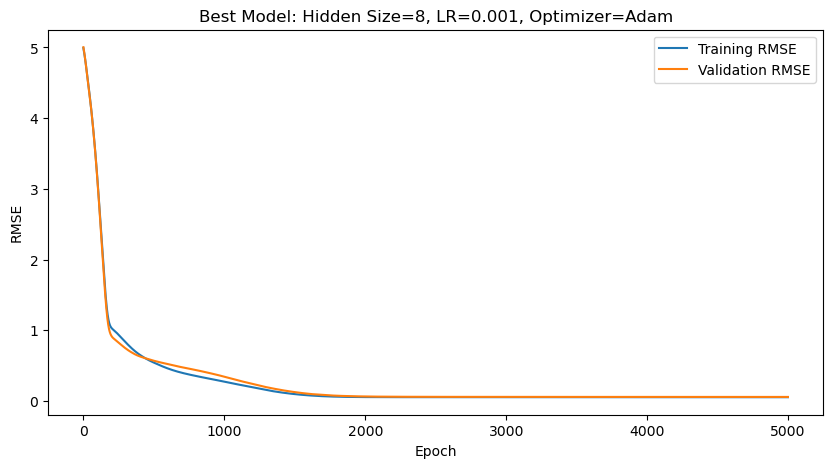

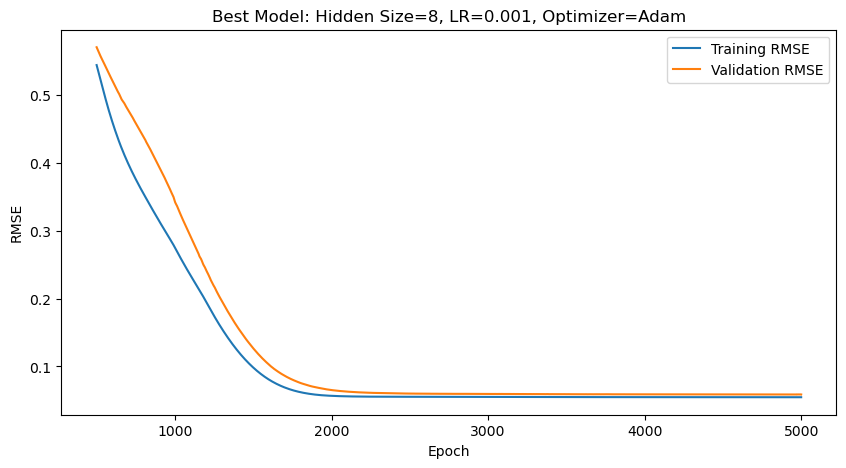

Best Validation RMSE: 0.0588
Best Parameters: {'hidden_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam', 'train_rmse_list': [4.992222841045191, 4.981069012540424, 4.96979708405088, 4.958329123273499, 4.946497963413185, 4.9342217487408355, 4.921736264165717, 4.909147342524487, 4.8963844584316, 4.883376139343615, 4.869956317368879, 4.856383160075092, 4.842633715562285, 4.8285881733866, 4.8143459594437035, 4.7997354434539865, 4.784866859871779, 4.769630624796544, 4.753954997631639, 4.738237775460079, 4.722444818274271, 4.706412044334271, 4.690242727867448, 4.673980136540212, 4.657691271668586, 4.641544340885715, 4.625527635324576, 4.6095185855549135, 4.593488620925417, 4.577655859334984, 4.561940616125838, 4.546117136085986, 4.530282594737727, 4.514405399343212, 4.4985527254368325, 4.4826510102790795, 4.4666183829663275, 4.450429857044776, 4.434205887670085, 4.417813757918978, 4.401217352917493, 4.384472428950216, 4.367565705056798, 4.350544178566424, 4.333473618999818, 4.31637266672

In [86]:
# Plotting RMSE
plt.figure(figsize=(10, 5))
plt.plot(best_params['train_rmse_list'], label='Training RMSE')
plt.plot(best_params['val_rmse_list'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
plt.legend()
plt.show()

# Plotting later epochs

plt.figure(figsize=(10, 5))
plt.plot(np.arange(500, 5000), best_params['train_rmse_list'][500:],  label='Training RMSE', )
plt.plot(np.arange(500, 5000),best_params['val_rmse_list'][500:], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
plt.legend()
plt.show()

print(f'Best Validation RMSE: {best_val_rmse:.4f}')
print(f'Best Parameters: {best_params}')

#### NN with Neuroevolution

In [27]:
sspace_nn = {
    'input_shape': X_train.shape[1],
    'init_factor': .01,
    'n_hidden_neurons': [4,4],
    'activation': [torch.relu, torch.relu, None],
    'n_output': 1,
    'n_batches': total_batches,
    'device': device
}

In [28]:
pi_sml = SMLNN(
    sspace=sspace_nn,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)

In [43]:
ps = 200
mutation_step = .01
mutation_prob = .5
xo_prob = 0.5
selection_pressure = .07
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=nn_init,
    selector=prm_tournament(pressure=selection_pressure),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    #
    # As in the example of using the traditional GSGP with GPOL, for Neuroevolution of the NN hyperparameters,
    # the algorithm is a GA object, and we specify the specific XO and Mutation operators.
    # In this case, however, to handle with NNs.
    #
    crossover=nn_xo,
    mutator=prm_nn_mtn(ms=mutation_step, sspace=sspace_nn)
)

In [44]:
mheuristic._initialize()

In [45]:
n_iter = 100
mheuristic.solve(
    n_iter,
    verbose=3, 
    # log=2, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 2        1.91325          1.92627               0.294 | 4.74729                  0.994363
1          | 2        1.83094          1.84396               0.637 | 2.96555                  0.504537
2          | 2        1.7984           1.81143               0.597 | 2.1346                   0.307884
3          | 2        1.77139          1.78442               0.568 | 1.8536                  0.0342528
4          | 2        1.7437           1.75672               0.594 | 

### NEAT

In [25]:
config_file = 'config-feedforward-xor'
with open(config_file, 'r') as f:
    print(f.read())

#--- parameters for the XOR-2 experiment ---#

#---------------------------------------------------------------------------------
[NEAT]
# The fitness_criterion is the function to be used 
# to compute the termination criterion from the set of 
# genome fitnesses. 
# When the fitness computed by fitness_criterion 
# meets or exceeds this threshold, the evolution 
# process will terminate, with a call to any 
# registered reporting class 'found_solution' method.
# Note
# The found_solution method is not called if the maximum 
# number of generations is reached without the above 
# threshold being passed.
fitness_criterion     = max
fitness_threshold     = -0.001

# If no_fitness_termination evaluates to True, 
# then the fitness_criterion and fitness_threshold are ignored 
# for termination; only valid if termination by a maximum number 
# of generations passed to population.Population.run() is enabled, 
# and the found_solution method is called upon 
# generation number termination.
no

In [26]:
config_file = 'config-feedforward-xor'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)


In [27]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    # print((fit/y.shape[0])**.5)
    return float((fit/y.shape[0])**.5)


def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments equals to the genomes and config objects.
    -> It has to update the `fitness` attribute of the genome.
    '''
    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Train fitness

        # Calculate as negative as we inverted problem to maximization for NEAT to work
        # It doesn't work with minimization for some reason
        genome.fitness = -eval_rmse(net, X_train, y_train)

        # Validation fitness
        genome.fitness_val = -eval_rmse(net, X_val, y_val)
        

In [28]:
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
# p.add_reporter(neat.Checkpointer(5))


In [42]:
winner = p.run(eval_genomes, 30)


 ****** Running generation 13 ****** 

Population's average fitness: -2.08818 stdev: 1.67160
Best fitness: -0.07890 - size: (1, 1) - species 9 - id 970
Average adjusted fitness: 0.730
Mean genetic distance 3.221, standard deviation 1.084
Population of 102 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    13     -0.8    0.658     4
     2   13     8     -0.7    0.702     0
     3   13     7     -2.0    0.623     0
     4   12    11     -3.9    0.570     6
     5   12    19     -0.2    0.857     0
     6   11    11     -0.9    0.764     2
     7   11     4     -0.9    0.789     2
     8    8     7     -0.2    0.921     3
     9    5    13     -0.1    0.894     3
    10    3     9     -3.9    0.521     0
Total extinctions: 0
Generation time: 0.877 sec (0.842 average)

 ****** Running generation 14 ****** 

Population's average fitness: -2.29199 stdev: 1.58281
Best fitness: -0.07890 - size: (1, 1) - species 9 - id 970

In [43]:
print('\nOutput:')

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

for xi, xo in zip(X_train[:10, :], y_train[:10]):
    output = winner_net.activate(xi)
    print("  expected output {!r}, got {!r}".format(xo, output))


Output:
  expected output tensor(4.8742), got [tensor(4.8822)]
  expected output tensor(4.8260), got [tensor(4.8849)]
  expected output tensor(4.8109), got [tensor(4.8785)]
  expected output tensor(4.8273), got [tensor(4.8807)]
  expected output tensor(4.8961), got [tensor(4.8878)]
  expected output tensor(4.8668), got [tensor(4.8875)]
  expected output tensor(4.9705), got [tensor(4.8768)]
  expected output tensor(4.9259), got [tensor(4.8855)]
  expected output tensor(4.9186), got [tensor(4.8759)]
  expected output tensor(4.8752), got [tensor(4.8761)]


In [44]:
print(str(winner))

Key: 2865
Fitness: -0.06355980038642883
Nodes:
	0 DefaultNodeGene(key=0, bias=4.890935761187438, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-5, 0), weight=-0.024189778472694143, enabled=True)


RMSE: [0.06355980038642883, 0.0679142102599144]


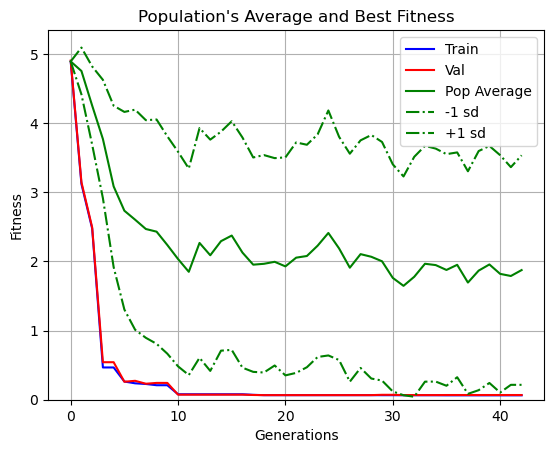

In [45]:
print('RMSE: {}'.format([-winner.fitness, -winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True,  view=True, filename= None)

### List of exercises

<hr />

##### **Exercise 1.a - Done**
**Implement the full and the ramped half-n-half initializers.**

\>> *The rhh initialization implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 1.b - Done**
**Implement the Hoist mutation.**

\>> *The hoist mutation implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2 - Done**
**Implement the double tournament selection algorithm.**

\>> *The Double tournament selection algorithm implementation will be evaluated in the final project. Its solution will be provided only after the project delivery, so it is an advanced implementation exercise.*

Double Tournament selection algorithm

It performs two sequential tournament selections, one for each objective, e.g., RMSE and tree size.

<hr />

<br />

<hr />

##### **Exercise 1  - Done**
**Implement the Geometric Semantic Crossover and Mutation proposed by Moraglio et al. 2012.**

\>> *The GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2  - Done**
**Implement the Efficient Geometric Semantic Crossover and Mutation proposed by Vanneschi et al. 2013.**

\>> *The Efficient GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<br />

> ##### **Exercise for extra points** - Done
**Implement a crossover and a mutation operators for evolving the weights and bias of a Neural Network.**

<br />